In [12]:
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import os
from sklearn.model_selection import train_test_split
import umap
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from scipy.optimize import minimize_scalar 
import tensorflow as tf 
PARAM_FILE = "params.yaml"
TARGET = 'total person income bin'

In [13]:
with open(PARAM_FILE, "r") as f:
    params = yaml.safe_load(f)
    train_data = pd.read_csv(params["cleaned_train_data_path"])
    test_data = pd.read_csv(params["cleaned_test_data_path"])
    metadata = pd.read_csv(params["column_metadata_path"])


assert len(train_data[TARGET].unique()) == 2
train_data[TARGET] = (train_data[TARGET]==' 50000+.').astype(int)
test_data[TARGET] = (test_data[TARGET]==' 50000+.').astype(int)

# Store the nominal and continuous feature names
select_nominal_features = np.loadtxt("data/nominal_features.txt", dtype=str, delimiter=",")
select_continuous_features = metadata[metadata['variable_type'] == 'continuous']['variable_name'].values
log_scale_vars = np.loadtxt("data/log_scale_vars.txt", dtype=str, delimiter=",")
# Selector for high income and low income rows
high_income_selector = train_data[TARGET] == 1

print("Im")


Im


## Preprocessing

### Continuous features
1. Scale data with large range using log transformation so that the data are more homogeneous on their range of variation.
2. Normalize Data Between 0 and 1.
    - Not all models require normalization. For example, decision trees do not require normalization.
    - Model that require are distance based models like KNN, SVM, etc, models that saturate like Neural Networks and models that are more easily interpretable when scaled like Linear Regression.
    - Normalization is done using the formula: 
        - $X_{norm} = \frac{X - X_{min}}{X_{max} - X_{min}}$
    - normaliation between 0 and 1 is favored over normal standardization because it preserves distribution shape of the data.

**Note:** When a normalization is applied to the data, we need to keep track of the min and max values so that the same transformation can be applied to the test data.


### Categorical features

1. Remove features that contain more than 50% missing values (`Not in universe`) see exploratory analysis.
2. Convert categorical features to numerical using dummy encoding.
    - Not all models require dummy encoding. Only model that interpret categorical features as numerical like linear regression require dummy encoding since other encoding such as label encoding would introduce ordinality to the data.
    [A,B,C,A] becomes

        | A | B | 
        |---|---|
        | 1 | 0 |
        | 0 | 1 |
        | 0 | 0 |
        | 1 | 0 | 
3. Label encoding is used for models that interpret categorical features as numerical like decision trees, random forests, etc.
    - Label encoding is done using the formula, each unique value is assigned a unique integer.
        - $X = \{X_1, X_2, X_3, X_4, X_5\}$
        - $X_{label} = \{1, 2, 3, 4, 5\}$

**Note:** When an encoding is applied to the data, we need to keep track of the unique values so that the same transformation can be applied to the test data.

In [14]:

def preprocess_data(data, categorical_encoding, normalize = False, preprocess_metadata = None):
    """
    Preprocess the data

    Parameters
    ----------
    data : pd.DataFrame
        The data to preprocess
    categorical_encoding : str
        The type of categorical encoding to use (dummy or label)
    normalize : bool (optional)
        Whether to normalize the continuous features
    preprocess_metadata : dict (optional)
        The metadata to use to process the data
    """
    processed_data = data[select_continuous_features].copy().reset_index(drop=True)
    processed_data[TARGET] = data[TARGET].reset_index(drop=True)
    ## Preprocess the data from scratch
    if preprocess_metadata is None:
        preprocess_metadata = {}
        
        if normalize:

            for feature in log_scale_vars:
                if feature in data.columns:
                    processed_data[feature] = np.log(processed_data[feature] + 1)
                scaler = MinMaxScaler()
                processed_data[select_continuous_features] = scaler.fit_transform(processed_data[select_continuous_features])
                preprocess_metadata['normalize'] = scaler

        if categorical_encoding == 'dummy':
            encoder = OneHotEncoder(drop='first', sparse_output=False)  
            encoder.fit(data[select_nominal_features])
            encoded_data = pd.DataFrame(encoder.transform(data[select_nominal_features]), columns=encoder.get_feature_names_out())
            processed_data = pd.concat([processed_data, encoded_data], axis=1)
            preprocess_metadata['encoder_dummy'] = encoder


    ## Reuse the metadata of a previous preprocessing
    else:
        if 'normalize' in preprocess_metadata:
            for feature in log_scale_vars:
                processed_data[feature] = np.log(data[feature] + 1)
            scaler = preprocess_metadata['normalize']
            processed_data[select_continuous_features] = scaler.transform(data[select_continuous_features])
        
        if "encoder_dummy" in preprocess_metadata:
            encoder = preprocess_metadata['encoder_dummy']
            encoded_data = pd.DataFrame(encoder.transform(data[select_nominal_features]), columns=encoder.get_feature_names_out())
            processed_data = pd.concat([processed_data, encoded_data], axis=1)
            
    return processed_data, preprocess_metadata

## Models

Before assessing the feature importances in predicting the income level, we need to create a model that predicts the income level. Several classes of models will be tested in order to create a landscape of the models that are best suited for the data. The models that will be tested are:

1. Logistic Regression (LR)
    This is a the linear regression for binary classification problems. 
    $$P(\text{income}>50k\$|X) = \frac{1}{1 + e^{-(\beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_nX_n)}}$$
    where $X$ is matrix of features and $\beta$ is the vector of coefficients.
    
    It is a simple model that is easy to interpret and is a good baseline for classification problems. The values of the coefficients can be used to assess the feature importances.

    **Note:** Since we  are interested in the feature importances, we will regularize the model using L1 regularization. This will force the model to select the most important features only.


    **preprocess:** The data will be normalized and so that the coefficients can be compared to each other. The categorical features will be dummy because the logistic regression requires numerical features and the dummy encoding will not introduce ordinality to the data.
    
2. Random Forest (RF)

    This is an ensemble model that is made up of decision trees. It is a non-linear model that is able to capture complex relationships in the data. It is also able to capture feature importances.

    This type of model is particularly interesting when trying to capture feature importances. It is easy to collect all the  increases in impurity (Gini index) that are attributed to each feature within the trees.

    **preprocess:** The data will **not** be normalized because decision trees are note sensitive to the range of the data. The categorical features will be dummy because the random forest requires numerical features and the dummy encoding will not introduce ordinality to the data.
    
3. Neural Network (NN)
    
    This a succession of layers of neurons (linear models) and non-linear activation functions that are able to capture complex relationships in the data. 

    This type of model is likely to provide the best performance in prediction but it is not easy to interpret the feature importances. However feature importances can be assessed using shapley values.

    Just like for the logistic regression, we will regularize the model using L1 regularization. This will force the model to select the most important features only.

    **preprocess:** The data will be normalized to prevent saturation of the neurons. The categorical features will be dummy because the neural network requires numerical features and the dummy encoding will not introduce ordinality to the data.

In [15]:
# logistic regression: call LogisticRegression()  function

# random forest: call RandomForestClassifier() function

# Create a NN class with the same API as the other models

def threshold_optimizer(y_pred,y_ref):
    """Optimize the threshold of a classifier to maximize the F1 score"""
    return minimize_scalar(lambda x: -f1_score(y_ref, y_pred > x), bounds=[0,1]).x

class NN:
    def __init__(self, batch_size=32, epochs=10, n_layers=2,first_layer_reg=0.01,n_inputs=407):
        self.epochs = epochs
        self.batch_size = batch_size
        self.threshold = 0.5
        assert n_layers >= 2, "The number of layers must be greater than 2 (input and output layers)"
        layer_sizes = np.linspace( n_inputs,1, n_layers, dtype=int)[1:-1]
        self.model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(n_inputs),
            *[tf.keras.layers.Dense(size, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(first_layer_reg)) for size in layer_sizes],
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC()])

    def fit(self, X, y):
        number_of_high_income = np.sum(y)
        X = tf.convert_to_tensor(X)
        y = tf.convert_to_tensor(y)
        class_weight = {0: 1.0, 1: (len(y) - number_of_high_income) / number_of_high_income}
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, class_weight=class_weight)
        y_pred = self.model.predict(X)
        self.threshold = threshold_optimizer(y_pred, y)
    
    def predict(self, X):
        X = tf.convert_to_tensor(X)
        return (self.model.predict(X) > self.threshold).astype(int).reshape(-1)
    
    def summary(self):
        return self.model.summary()
    
algo_dict = {
    "logistic_regression": LogisticRegression,
    "random_forest": RandomForestClassifier,
    "neural_network": NN
}

The network uses L1 regularization to force the model to select the most important features only. The output of the model is a continous value between 0 and 1. We will optimize the threshold to maximize the F1 score.

## hyperparameter tuning

For each model, we will use a grid search to find the best hyperparameters. A grid search is a brute force method that tries all the possible combinations of hyperparameters.

Given the small time frame  for this project, we will not use the complete dataset to find the best hyperparameters. Instead, we will use two subsets of the data to find the best hyperparameters. The first subset will be used to fit the model and the second subset will be used to validate the model. The best hyperparameters will be the ones that maximize the F1 score (see part on scoring) on the validation set. Once the best hyperparameters are found, the model will be trained on the complete training dataset.

Here a the parameters that will be tuned for each model:

1. Logistic Regression
    - C: The inverse of the regularization strength. Smaller values specify stronger regularization.

2. Random Forest
    - n_estimators: The number of trees in the forest.
    - max_depth: The maximum depth of the trees.
    - min_samples_split: The minimum number of samples required to split an internal node.
    - min_samples_leaf: The minimum number of samples required to be at a leaf node.

3. Neural Network

    - batch_size: The number of samples to use in each batch.
    - epochs: The number of epochs to train the model.
    - n_layers: The number of layers
    - first_layer_reg: The L1 regularization parameter.

## Scoring

The most tempting metric to use for scoring the models is the accuracy (percentage of income labels that were correct). However, the accuracy is not a good metric for this problem because the classes are imbalanced (92% vs 8%) and a model that always predicts the majority class would have an accuracy of 92%.

Instead one need to take a look at the confusion matrix and the precision:

![confusion mastrix](figures/example_confusion.png)  
source: https://en.wikipedia.org/wiki/Confusion_matrix

To be comparable with a generic confusion matrix, the label positive will be the `>50k$` class and the label negative will be the `<=50k$` class. Lookin at this matrix we can understand that the accuracy is concerned with the diagonal of the matrix. To get a better understanding of the model, we need to look at the precision and recall.

- Precision: The precision is the number of true positive divided by the number of true positive and false positive. It is the ability of the classifier not to label as positive a sample that is negative.
    - $P = \frac{TP}{TP + FP}$  
    example: when detecting spams, it is an important metric because we want to avoid false positive (labeling a non-spam as spam).

- Recall: The recall is the number of true positive divided by the number of true positive and false negative. It is the ability of the classifier to find all the positive samples.
    - $R = \frac{TP}{TP + FN}$  
    example: when detecting cancer, it is an important metric because we want to avoid false negative (labeling a cancer as non-cancer).

Depending on the problem, we might want to favor precision over recall or the opposite. In our problem though, both precision and recall are important, there exist an other metric that is a combination of both, the F1 score:

- F1 score: The F1 score is the harmonic mean of the precision and recall. It is a good metric to use when the classes are imbalanced.
    - $F1 = 2 \times \frac{P \times R}{P + R}$

The F1 score will be the metric used to compare the models but we will also look at the confusion matrix to understand the behavior of the models.


**Note:** The evaluation score may differ from the training score. The training score is chosen because in is convenient to use in a gradient descent for example (ex: mean square error or cross entropy). It is also called the **loss function**. 

### Classification threshold

Some models (only neural network in our case) do not output a class but a continous value between the two classes 0 and 1. To create a class, we need to choose a threshold above which the class is 1 and below which the class is 0. It is common to choose 0.5 as the threshold but this is arbitrary. We will use the threshold that maximizes the F1 score on the validation set.

![threshold](figures/threshold_optimization.svg) 

## Handling imbalanced classes  

We use two techniques to handle the imbalanced classes:

1. stratified sampling: The training and validation sets are created using stratified sampling. This means that the proportion of the classes in the training and validation sets are the same as the proportion of the classes in the complete dataset. When a class is underrepresented, there is the risk that a split of the data would not contain any occurence of that class. Stratified sampling prevents this from happening.

2. class weights: The class weights are used to penalize the model when it makes a mistake on the minority class. This is done by multiplying the loss function by the class weights. The class weights are the inverse of the class proportions. This means that the model is penalized more when it makes a mistake on the minority class. It affect the fit in a similar way as oversampling the minority class but without the need to add synthetic data or duplicates.

3. It's clear that the class imbalance is a problem for random forest as the bootstrapping will likely create datasets that do not contain any occurence of the minority class. Hopefully, a high enough number of trees will be able to capture the minority class but is probable that random forest will not perform well on this dataset.

In [16]:
## Diffine the hyperparameters for each model

# Logistic regression
logistic_regression_hyperparameters = {
    "C": np.logspace(-3, 3, 7),
    "class_weight": [None, "balanced"]
}

# Random forest
random_forest_hyperparameters = {
    "n_estimators": [50, 100, 200],
    "max_depth": [5, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2, 4]
}

# Neural network
neural_network_hyperparameters = {
    "batch_size": [32, 64],
    "epochs": [5, 10, 20],
    "n_layers": [3, 4],
    "first_layer_reg": [0.01, 0.1]
}
hyperparameter_algos = {
    "logistic_regression": logistic_regression_hyperparameters,
    "random_forest": random_forest_hyperparameters,
    "neural_network": neural_network_hyperparameters
}

def sample_data(data,fractions):
    """
    Sample the data into subsets, keeping the same distribution of the target variable

    Parameters
    ----------
    data : pd.DataFrame
        The data to sample
    fractions : list
        The fractions to sample 
    """
    splits = []
    assert np.sum(fractions) < 1, "The sum of the fractions must be  lower than 1"
    high_income_data = data[high_income_selector].sample(frac=1)
    low_income_data = data[~high_income_selector].sample(frac=1)
    start_index_high = 0
    start_index_low = 0
    for fraction in fractions:
        end_index_high = start_index_high + int(fraction * len(high_income_data))
        end_index_low = start_index_low + int(fraction * len(low_income_data))
        high_income_split = high_income_data[start_index_high:end_index_high]
        low_income_split = low_income_data[start_index_low:end_index_low]
        splits.append(pd.concat([high_income_split, low_income_split]).sample(frac=1))
        start_index_high = end_index_high
        start_index_low = end_index_low
    return splits

In [17]:
## Create the small train and validation sets
small_train,small_val = sample_data(train_data, [0.1, 0.1])
small_all = pd.concat([small_train, small_val])

In [18]:
hyperparameter_algos

{'logistic_regression': {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
  'class_weight': [None, 'balanced']},
 'random_forest': {'n_estimators': [50, 100, 200],
  'max_depth': [5, 10, 20],
  'min_samples_split': [2, 5],
  'min_samples_leaf': [1, 2, 4]},
 'neural_network': {'batch_size': [32, 64],
  'epochs': [5, 10, 20],
  'n_layers': [3, 4],
  'first_layer_reg': [0.01, 0.1]}}

In [19]:

## Optimize the hyperparameters of the models
hyperparameter_opti = {}
for algo_name,algo in algo_dict.items():
    hyperparameter_dict = hyperparameter_algos[algo_name]
    if algo_name == "random_forest":
        X = preprocess_data(small_all, "dummy", False)[0]
    else:
        X = preprocess_data(small_all, "dummy", True)[0]
    y = X[TARGET]
    X = X.drop(TARGET, axis=1)
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.5, shuffle=False)

    def objective(trial):
        hyperparameters = {
            name: trial.suggest_categorical(name, choices) for name, choices in hyperparameter_dict.items()
        }
        if algo_name == "neural_network":
            hyperparameters['n_inputs'] = X_train.shape[1]
        model = algo(**hyperparameters)
        model.fit(X_train, y_train)
        y_pred =  model.predict(X_valid)
        trial.set_user_attr("accuracy", accuracy_score(y_valid, y_pred)) 
        return f1_score(y_valid, y_pred)
    
    study = study = optuna.create_study(sampler=optuna.samplers.GridSampler(hyperparameter_dict), direction="maximize")
    study.optimize(objective, n_trials=sum([len(choices) for choices in hyperparameter_dict.values()]))
    hyperparameter_opti[algo_name] = study


[I 2024-02-22 09:39:41,959] A new study created in memory with name: no-name-67ecb605-35a7-469e-8489-5c61254a8b47
/Users/adrien/anaconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[I 2024-02-22 09:39:42,740] Trial 0 finished with value: 0.4454855195911414 and parameters: {'C': 10.0, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.4454855195911414.
/Users/adrien/anaconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):


Epoch 1/5


2024-02-22 09:39:57.125248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


478/478 [==============================] - 8s 11ms/step - loss: 35.5078 - binary_accuracy: 0.5840 - auc: 0.4847
Epoch 2/5
478/478 [==============================] - 5s 10ms/step - loss: 1.9620 - binary_accuracy: 0.4136 - auc: 0.4863
Epoch 3/5
478/478 [==============================] - 5s 11ms/step - loss: 1.9609 - binary_accuracy: 0.6395 - auc: 0.4862
Epoch 4/5
478/478 [==============================] - 5s 11ms/step - loss: 1.9599 - binary_accuracy: 0.3822 - auc: 0.4964
Epoch 5/5
478/478 [==============================] - 1s 1ms/step


[I 2024-02-22 09:40:26,847] Trial 0 finished with value: 0.14922480620155038 and parameters: {'batch_size': 32, 'epochs': 5, 'n_layers': 4, 'first_layer_reg': 0.1}. Best is trial 0 with value: 0.14922480620155038.


Epoch 1/5
239/239 [==============================] - 3s 11ms/step - loss: 8.3838 - binary_accuracy: 0.6425 - auc_1: 0.8045
Epoch 2/5
239/239 [==============================] - 3s 11ms/step - loss: 1.1794 - binary_accuracy: 0.7162 - auc_1: 0.8561
Epoch 3/5
239/239 [==============================] - 2s 10ms/step - loss: 1.1058 - binary_accuracy: 0.7522 - auc_1: 0.8705
Epoch 4/5
239/239 [==============================] - 2s 10ms/step - loss: 1.0782 - binary_accuracy: 0.7588 - auc_1: 0.8769
Epoch 5/5
478/478 [==============================] - 1s 1ms/step


[I 2024-02-22 09:40:41,577] Trial 1 finished with value: 0.4884979702300406 and parameters: {'batch_size': 64, 'epochs': 5, 'n_layers': 4, 'first_layer_reg': 0.01}. Best is trial 1 with value: 0.4884979702300406.


Epoch 1/10
239/239 [==============================] - 3s 10ms/step - loss: 37.4167 - binary_accuracy: 0.6475 - auc_2: 0.6046
Epoch 2/10
239/239 [==============================] - 2s 9ms/step - loss: 1.6574 - binary_accuracy: 0.5716 - auc_2: 0.5112
Epoch 3/10
239/239 [==============================] - 2s 9ms/step - loss: 1.6560 - binary_accuracy: 0.4518 - auc_2: 0.5117
Epoch 4/10
239/239 [==============================] - 2s 9ms/step - loss: 1.6548 - binary_accuracy: 0.4340 - auc_2: 0.5139
Epoch 5/10
239/239 [==============================] - 2s 9ms/step - loss: 1.6551 - binary_accuracy: 0.6813 - auc_2: 0.5170
Epoch 6/10
239/239 [==============================] - 2s 9ms/step - loss: 1.6543 - binary_accuracy: 0.4669 - auc_2: 0.5107
Epoch 7/10
239/239 [==============================] - 2s 9ms/step - loss: 1.6537 - binary_accuracy: 0.5693 - auc_2: 0.5125
Epoch 8/10
239/239 [==============================] - 2s 9ms/step - loss: 1.6543 - binary_accuracy: 0.3930 - auc_2: 0.5073
Epoch 9/10
239

[I 2024-02-22 09:41:05,921] Trial 2 finished with value: 0.14922480620155038 and parameters: {'batch_size': 64, 'epochs': 10, 'n_layers': 3, 'first_layer_reg': 0.1}. Best is trial 1 with value: 0.4884979702300406.


Epoch 1/20
239/239 [==============================] - 3s 11ms/step - loss: 68.6665 - binary_accuracy: 0.5778 - auc_3: 0.5214
Epoch 2/20
239/239 [==============================] - 3s 11ms/step - loss: 1.9658 - binary_accuracy: 0.2099 - auc_3: 0.4938
Epoch 3/20
239/239 [==============================] - 3s 10ms/step - loss: 1.9625 - binary_accuracy: 0.7695 - auc_3: 0.4972
Epoch 4/20
239/239 [==============================] - 3s 11ms/step - loss: 1.9624 - binary_accuracy: 0.5436 - auc_3: 0.4904
Epoch 5/20
239/239 [==============================] - 2s 10ms/step - loss: 1.9626 - binary_accuracy: 0.4013 - auc_3: 0.4827
Epoch 6/20
239/239 [==============================] - 2s 10ms/step - loss: 1.9618 - binary_accuracy: 0.3281 - auc_3: 0.4930
Epoch 7/20
239/239 [==============================] - 2s 10ms/step - loss: 1.9610 - binary_accuracy: 0.3746 - auc_3: 0.4930
Epoch 8/20
239/239 [==============================] - 3s 12ms/step - loss: 1.9612 - binary_accuracy: 0.5056 - auc_3: 0.4914
Epoch 9

[I 2024-02-22 09:41:58,491] Trial 3 finished with value: 0.14922480620155038 and parameters: {'batch_size': 64, 'epochs': 20, 'n_layers': 4, 'first_layer_reg': 0.1}. Best is trial 1 with value: 0.4884979702300406.


Epoch 1/10
478/478 [==============================] - 6s 11ms/step - loss: 35.5047 - binary_accuracy: 0.5681 - auc_4: 0.5254
Epoch 2/10
478/478 [==============================] - 5s 10ms/step - loss: 1.9611 - binary_accuracy: 0.5712 - auc_4: 0.4942
Epoch 3/10
478/478 [==============================] - 5s 11ms/step - loss: 1.9587 - binary_accuracy: 0.6915 - auc_4: 0.4944
Epoch 4/10
478/478 [==============================] - 5s 10ms/step - loss: 1.9589 - binary_accuracy: 0.3483 - auc_4: 0.4803
Epoch 5/10
478/478 [==============================] - 5s 10ms/step - loss: 1.9582 - binary_accuracy: 0.4533 - auc_4: 0.4817
Epoch 6/10
478/478 [==============================] - 5s 10ms/step - loss: 1.9578 - binary_accuracy: 0.4024 - auc_4: 0.4902
Epoch 7/10
478/478 [==============================] - 5s 10ms/step - loss: 1.9566 - binary_accuracy: 0.7321 - auc_4: 0.4905
Epoch 8/10
478/478 [==============================] - 5s 10ms/step - loss: 1.9569 - binary_accuracy: 0.4017 - auc_4: 0.4914
Epoch 9

[I 2024-02-22 09:42:50,774] Trial 4 finished with value: 0.14922480620155038 and parameters: {'batch_size': 32, 'epochs': 10, 'n_layers': 4, 'first_layer_reg': 0.1}. Best is trial 1 with value: 0.4884979702300406.


Epoch 1/10
239/239 [==============================] - 3s 11ms/step - loss: 8.4228 - binary_accuracy: 0.6262 - auc_5: 0.8058
Epoch 2/10
239/239 [==============================] - 3s 12ms/step - loss: 1.1703 - binary_accuracy: 0.7250 - auc_5: 0.8548
Epoch 3/10
239/239 [==============================] - 3s 10ms/step - loss: 1.0878 - binary_accuracy: 0.7511 - auc_5: 0.8698
Epoch 4/10
239/239 [==============================] - 2s 10ms/step - loss: 1.0474 - binary_accuracy: 0.7683 - auc_5: 0.8796
Epoch 5/10
239/239 [==============================] - 2s 10ms/step - loss: 1.0259 - binary_accuracy: 0.7753 - auc_5: 0.8848
Epoch 6/10
239/239 [==============================] - 3s 12ms/step - loss: 1.0086 - binary_accuracy: 0.7853 - auc_5: 0.8896
Epoch 7/10
239/239 [==============================] - 3s 11ms/step - loss: 0.9940 - binary_accuracy: 0.7849 - auc_5: 0.8935
Epoch 8/10
239/239 [==============================] - 2s 10ms/step - loss: 0.9839 - binary_accuracy: 0.7942 - auc_5: 0.8962
Epoch 9/

[I 2024-02-22 09:43:18,949] Trial 5 finished with value: 0.5160328113348247 and parameters: {'batch_size': 64, 'epochs': 10, 'n_layers': 4, 'first_layer_reg': 0.01}. Best is trial 5 with value: 0.5160328113348247.


Epoch 1/5
239/239 [==============================] - 3s 10ms/step - loss: 4.9959 - binary_accuracy: 0.6422 - auc_6: 0.8213
Epoch 2/5
239/239 [==============================] - 2s 10ms/step - loss: 1.1503 - binary_accuracy: 0.7183 - auc_6: 0.8507
Epoch 3/5
239/239 [==============================] - 2s 10ms/step - loss: 1.0940 - binary_accuracy: 0.7357 - auc_6: 0.8581
Epoch 4/5
239/239 [==============================] - 2s 9ms/step - loss: 1.0673 - binary_accuracy: 0.7470 - auc_6: 0.8630
Epoch 5/5
478/478 [==============================] - 1s 1ms/step


[I 2024-02-22 09:43:32,424] Trial 6 finished with value: 0.4467892674103105 and parameters: {'batch_size': 64, 'epochs': 5, 'n_layers': 3, 'first_layer_reg': 0.01}. Best is trial 5 with value: 0.5160328113348247.


Epoch 1/10
478/478 [==============================] - 5s 10ms/step - loss: 19.5987 - binary_accuracy: 0.5431 - auc_7: 0.5482
Epoch 2/10
478/478 [==============================] - 4s 9ms/step - loss: 1.6576 - binary_accuracy: 0.6542 - auc_7: 0.5186
Epoch 3/10
478/478 [==============================] - 4s 9ms/step - loss: 1.6569 - binary_accuracy: 0.4308 - auc_7: 0.5087
Epoch 4/10
478/478 [==============================] - 5s 10ms/step - loss: 1.6570 - binary_accuracy: 0.5501 - auc_7: 0.5077
Epoch 5/10
478/478 [==============================] - 5s 9ms/step - loss: 1.6552 - binary_accuracy: 0.6497 - auc_7: 0.5164
Epoch 6/10
478/478 [==============================] - 4s 9ms/step - loss: 1.6567 - binary_accuracy: 0.3768 - auc_7: 0.5058
Epoch 7/10
478/478 [==============================] - 4s 9ms/step - loss: 1.6560 - binary_accuracy: 0.2905 - auc_7: 0.5045
Epoch 8/10
478/478 [==============================] - 4s 9ms/step - loss: 1.6570 - binary_accuracy: 0.4588 - auc_7: 0.5119
Epoch 9/10
47

[I 2024-02-22 09:44:19,327] Trial 7 finished with value: 0.14922480620155038 and parameters: {'batch_size': 32, 'epochs': 10, 'n_layers': 3, 'first_layer_reg': 0.1}. Best is trial 5 with value: 0.5160328113348247.


Epoch 1/20
239/239 [==============================] - 3s 11ms/step - loss: 5.0478 - binary_accuracy: 0.6578 - auc_8: 0.8169
Epoch 2/20
239/239 [==============================] - 2s 9ms/step - loss: 1.1592 - binary_accuracy: 0.7120 - auc_8: 0.8470
Epoch 3/20
239/239 [==============================] - 2s 9ms/step - loss: 1.0975 - binary_accuracy: 0.7375 - auc_8: 0.8578
Epoch 4/20
239/239 [==============================] - 2s 9ms/step - loss: 1.0658 - binary_accuracy: 0.7429 - auc_8: 0.8635
Epoch 5/20
239/239 [==============================] - 2s 9ms/step - loss: 1.0491 - binary_accuracy: 0.7516 - auc_8: 0.8664
Epoch 6/20
239/239 [==============================] - 2s 9ms/step - loss: 1.0266 - binary_accuracy: 0.7563 - auc_8: 0.8708
Epoch 7/20
239/239 [==============================] - 2s 9ms/step - loss: 1.0195 - binary_accuracy: 0.7611 - auc_8: 0.8706
Epoch 8/20
239/239 [==============================] - 2s 9ms/step - loss: 1.0000 - binary_accuracy: 0.7627 - auc_8: 0.8755
Epoch 9/20
239/

[I 2024-02-22 09:45:06,120] Trial 8 finished with value: 0.5134649910233393 and parameters: {'batch_size': 64, 'epochs': 20, 'n_layers': 3, 'first_layer_reg': 0.01}. Best is trial 5 with value: 0.5160328113348247.


<Axes: xlabel='F1-score', ylabel='Accuracy'>

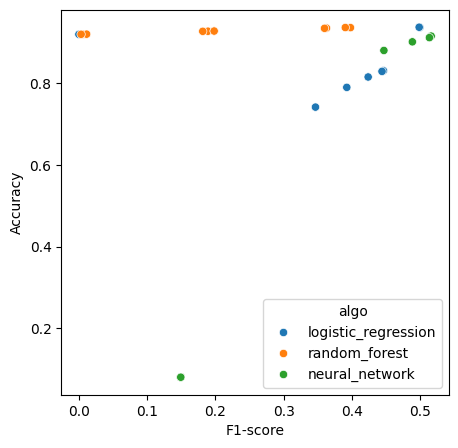

In [20]:
hyperparameter_scores = []
for algo_name,study in hyperparameter_opti.items():
    opti = hyperparameter_opti[algo_name]
    hyperparameter_scores += [{"F1-score":pset._values[0],"Accuracy":pset._user_attrs["accuracy"], "algo":algo_name,"fit type":"hyperparameter search"} for pset in opti.get_trials()]
hyperparameter_scores = pd.DataFrame(hyperparameter_scores)

plt.figure(figsize=(5, 5))
sns.scatterplot(data=hyperparameter_scores, x="F1-score", y="Accuracy", hue="algo")

Among all the models tested, the neural network performs the best in terms of F1 score and demonstrates robustness with respect to its hyperparameters. The logistic regression also performs well but it is not as robust as the neural network. The random forest performs poorly on the F1 score. The neural network is probably the model that will be used to assess the feature importances.

## Model true training

We will train the three models on the complete training set using the best hyperparameters found during the hyperparameter tuning. The models will be trained using the class weights to handle the imbalanced classes.

In [21]:
trainded_models = {}
preprocess_metadata = {}
complete_model_scores = []
training_sample,validation_sample = sample_data(train_data, [0.8, 0.1999])

for model_name, study in hyperparameter_opti.items():
    print(f"Best hyperparameters for {model_name}: {study.best_params}")
    params = study.best_params
    if model_name == "neural_network":
            params['n_inputs'] = X_train.shape[1]
    model = algo_dict[model_name](**params)
    if model_name == "random_forest":
        X_train,preprocess_metadata[model_name] = preprocess_data(train_data, "dummy", False)
        X_valid,_ = preprocess_data(train_data, "dummy", False, preprocess_metadata[model_name])
    else:
        X_train,preprocess_metadata[model_name] = preprocess_data(train_data, "dummy", True)
        X_valid,_ = preprocess_data(train_data, "dummy", True, preprocess_metadata[model_name])
    y_train = X_train[TARGET]
    X_train = X_train.drop(TARGET, axis=1)

    y_valid = X_valid[TARGET]
    X_valid = X_valid.drop(TARGET, axis=1)

    model.fit(X_train, y_train)
    trainded_models[model_name] = model
    
    complete_model_scores+= [{"F1-score":f1_score(y_valid, model.predict(X_valid)),"Accuracy":accuracy_score(y_valid, model.predict(X_valid)), "algo":model_name,"fit type":"complete model"}]
    y_pred = model.predict(X_valid)




Best hyperparameters for logistic_regression: {'C': 100.0, 'class_weight': None}
Best hyperparameters for random_forest: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1}
Best hyperparameters for neural_network: {'batch_size': 64, 'epochs': 10, 'n_layers': 4, 'first_layer_reg': 0.01}
Epoch 1/10
2388/2388 [==============================] - 27s 11ms/step - loss: 1.7453 - binary_accuracy: 0.7708 - auc_9: 0.8849
Epoch 2/10
2388/2388 [==============================] - 26s 11ms/step - loss: 0.9264 - binary_accuracy: 0.8102 - auc_9: 0.9107
Epoch 3/10
2388/2388 [==============================] - 26s 11ms/step - loss: 0.8936 - binary_accuracy: 0.8190 - auc_9: 0.9160
Epoch 4/10
2388/2388 [==============================] - 25s 10ms/step - loss: 0.8736 - binary_accuracy: 0.8241 - auc_9: 0.9185
Epoch 5/10
2388/2388 [==============================] - 26s 11ms/step - loss: 0.8542 - binary_accuracy: 0.8264 - auc_9: 0.9199
Epoch 6/10
2388/2388 [======================

In [25]:
complete_model_scores= pd.DataFrame(complete_model_scores)

<Axes: xlabel='algo', ylabel='F1-score'>

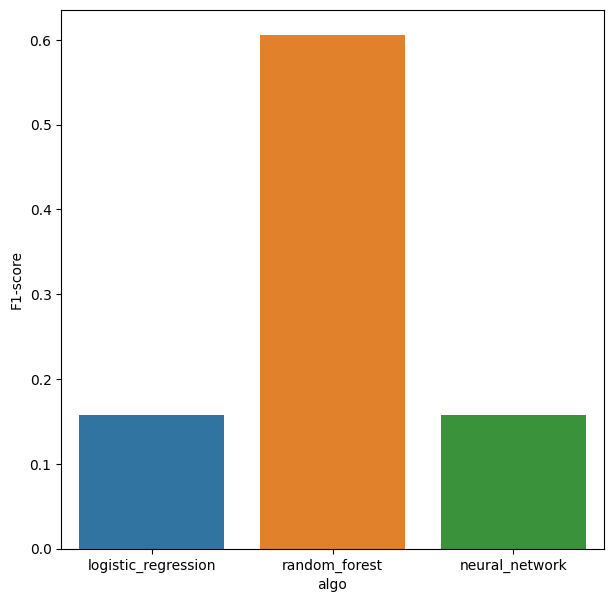

In [31]:
plt.figure(figsize=(7, 7))
sns.barplot(data=complete_model_scores, x="algo", y="F1-score", hue="algo")

Surprisingly, the random forest model exhibits the best performance on the validation set. In contrast, the neural network demonstrates a decrease in performance when compared to its performance on smaller training and validation sets.

Seeing more samples, the random forest is able to capture the minority class better than it was able to do on the smaller training and validation sets.

For the next steps, we will use the random forest model to assess the feature importances.

### check neural network confusion matrix

In [ ]:
preprocess_metadata.keys()

dict_keys(['logistic_regression', 'random_forest', 'neural_network'])

In [ ]:
X_valid,_ = preprocess_data(train_data, "dummy", False, preprocess_metadata["neural_network"])
y_valid = X_valid[TARGET]
X_valid = X_valid.drop(TARGET, axis=1)
y_pred = trainded_models["neural_network"].predict(X_valid)

4776/4776 [==============================] - 20s 4ms/step


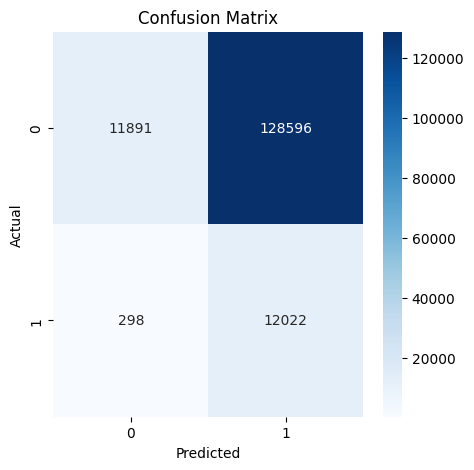

F1-score: 0.15721403444533077
Accuracy: 0.15649152198524938
Precision: 0.0854940334807777
Recall: 0.9758116883116883
[[ 11891 128596]
 [   298  12022]]


In [ ]:
plt.figure(figsize=(5, 5))
cm = confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
print(f"F1-score: {f1_score(y_valid, y_pred)}")
print(f"Accuracy: {accuracy_score(y_valid, y_pred)}")
print(f"Precision: {precision_score(y_valid, y_pred)}")
print(f"Recall: {recall_score(y_valid, y_pred)}")
print(cm)

As expected for such a imbalanced dataset, the neural network has a high recall but a low precision. 

## Test the models on the test set

The models will be tested on the test set and the F1 score will be used to compare the models. The model that performs the best will be used to assess the feature importances.

In [ ]:
model_name = "random_forest"
X, _ = preprocess_data(test_data, "dummy", True, preprocess_metadata[model_name])
y = X[TARGET]
X = X.drop(TARGET, axis=1)
y_pred = trainded_models[model_name].predict(X)
print(f"F1-score for {model_name}: {f1_score(y, y_pred)}")
print(f"Accuracy for {model_name}: {accuracy_score(y, y_pred)}")
print(f"Confusion matrix for {model_name}:")
print(confusion_matrix(y, y_pred))
print(f"Precision for {model_name}: {precision_score(y, y_pred)}")
print(f"Recall for {model_name}: {recall_score(y, y_pred)}")
print("\n")

F1-score for random_forest: 0.4280735488523014
Accuracy for random_forest: 0.9396265191688021
Confusion matrix for random_forest:
[[72286   376]
 [ 4383  1781]]
Precision for random_forest: 0.8256838201205378
Recall for random_forest: 0.2889357560025957




Evaluate the model on the test set and compare the F1.


In [ ]:
plt.figure(figsize=(5, 5))
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Feature importance
Since the best model is the random forest, we will use the feature importances from the random forest to assess the feature importances. 

In a decision tree a split of a node is made to minimize the impurity (Gini index). The feature importances for a feature is the sum of the impurity decreases for all the nodes in all the trees that used that feature for a split.

**Note:** The dummy encoding has split the categorical features into multiple features. The feature importance for a categorical feature is the sum of the feature importances of all the features that were created from the categorical feature.

In [ ]:
dummy_columns = X.columns
old_columns = np.concatenate([select_continuous_features, select_nominal_features])
dummy_feature_importances = pd.Series(trainded_models[model_name].feature_importances_, index=dummy_columns)
feature_importances = pd.Series(np.zeros(len(old_columns)), index=old_columns)

In [ ]:
for col in dummy_columns:
    if "_" in col:
        feature_importances[col.split("_")[0]]+= dummy_feature_importances[col]
    else:
        feature_importances[col]+= dummy_feature_importances[col]

In [ ]:
feature_importances = feature_importances.sort_values(ascending=False)

Text(0, 0.5, 'Importance')

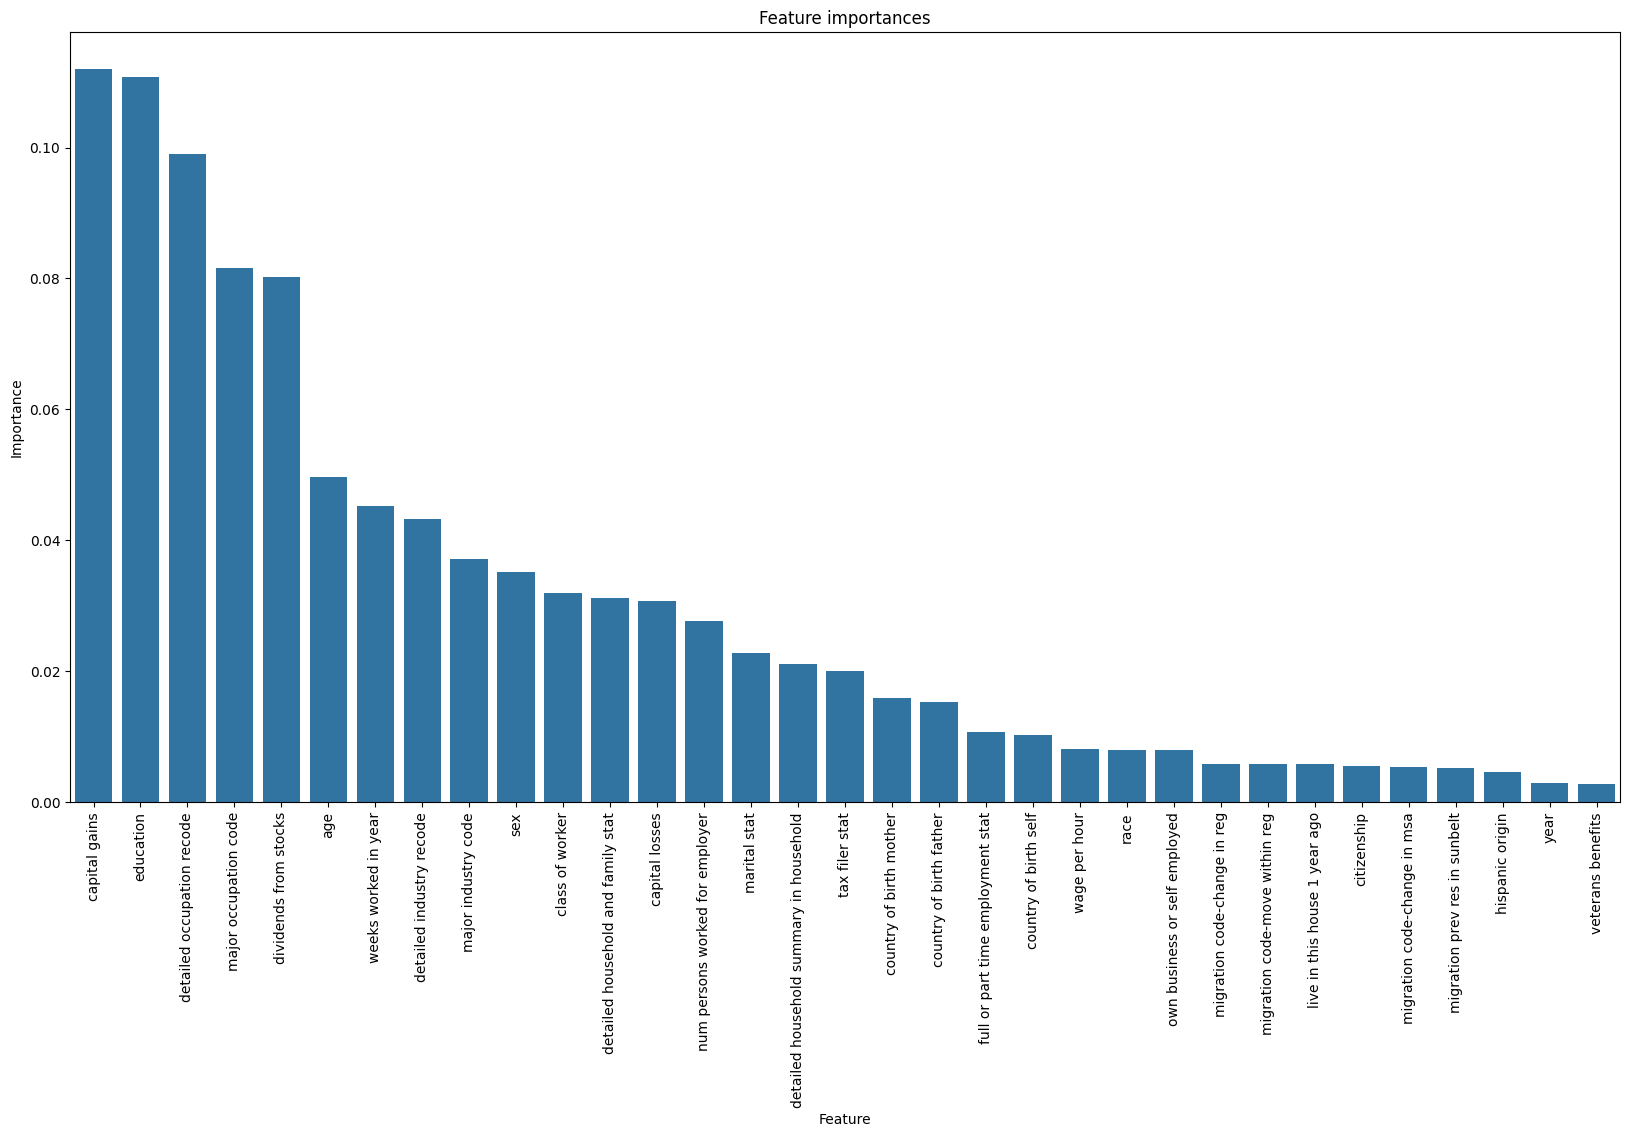

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(x=feature_importances.index, y=feature_importances)
plt.xticks(rotation=90)
plt.title("Feature importances")
plt.xlabel("Feature")
plt.ylabel("Importance")

In [ ]:
best_5 = feature_importances.index[:5]

In [ ]:
best_5

Index(['capital gains', 'education', 'detailed occupation recode',
       'major occupation code', 'dividends from stocks'],
      dtype='object')

X, _ = preprocess_data(test_data, "dummy", True, preprocess_metadata[model_name])
y = X[TARGET]
X = X.drop(TARGET, axis=1)

In [ ]:
X_train , exp_metadata = preprocess_data(train_data, "dummy", False)
y_train = X_train[TARGET]
X_test , _ = preprocess_data(test_data, "dummy", False, exp_metadata)
y_test = X_test[TARGET]
X_train = X_train[[col for col in X_train.columns if np.any([bb==col[:len(bb)] in bb for bb in best_5])]]
X_test = X_test[[col for col in X_test.columns if np.any([bb==col[:len(bb)] in bb for bb in best_5])]]

model_name = "random_forest"
model= algo_dict[model_name](**hyperparameter_opti[model_name].best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
print(f"F1-score for {model_name}: {f1_score(y_test, y_pred)}")
print(f"Accuracy for {model_name}: {accuracy_score(y_test, y_pred)}")
print(f"Confusion matrix for {model_name}:")
print(confusion_matrix(y_test, y_pred))
print(f"Precision for {model_name}: {precision_score(y_test, y_pred)}")
print(f"Recall for {model_name}: {recall_score(y_test, y_pred)}")
print("\n")

F1-score for random_forest: 0.38778877887788776
Accuracy for random_forest: 0.9341080354197854
Confusion matrix for random_forest:
[[71987   675]
 [ 4519  1645]]
Precision for random_forest: 0.709051724137931
Recall for random_forest: 0.26687216093445815


